In [81]:
import numpy as np
import scipy
import scipy.sparse as sparse
import matplotlib.pyplot as plt
import matplotlib.colors as clrs
import time
import multiprocessing
import os
from copy import deepcopy
import numpy.ma as ma

In [21]:
%run ../methodsMemoryDeposition

In [11]:
def main(params):
    foldername = params["foldername"]

    if params['seed'] is None:
        np.random.seed(); params['seed'] = 0
    else:
        np.random.seed(params['seed'])
        
    width = params["dom"]
    d = params["ndim"]
    params["max_CDF"] = max_CDF(params)
    csv_name = foldername + 'sim_%.2er0_%dL_%dseed.csv'%(params['r_0'], params['dom'],int(params['seed']))
    t = n_ptcls = n_snapshot = 0

    with open(csv_name,'w') as outfile:
        if params["Whole_Lattice"]:
            print('t, num_active_sites, N, h_mean, h_std, trans_len, paral_len,',
                  'density_last_interval, empty_bond_mass, empty_bond_volume, mean_bond_size',file=outfile)
        else: print('t, num_active_sites, N, h_mean, h_std, trans_len, paral_len',file=outfile)


    shape = tuple(width for _ in range(d)) #Shape is the tuple with the dimension sizes
    max_height_flat = np.zeros((np.power(width, d)), dtype=int) #occupation/height at each site

    #Here comes all the if statements for Different Run conditions

    if params["keep_all"]: #Fuck this part
        max_height_time = [] 
        times = []

    if params["Whole_Lattice"]: # Needs an extra big array
        if np.isinf(params["height"]):
            raise RuntimeError("This is not gonna work buddy")
        
        space_flat = np.zeros((np.power(width, d), params["height"]), dtype=int)#occupation/height at each site
        global_max_height_prev = 0
    
    if params["init_cond"] == "homogenous": #Coffee Percolation
        t_next = np.array([single_time(0, params) for _ in range(np.power(width, d))])
    elif params["init_cond"] == "single": #Infection Percolation
        t_next = np.full(np.power(width, d), np.inf)
        while(t_next[int(len(t_next)/2)] == np.inf):
            t_next[int(len(t_next)/2)] = single_time(0, params)
    else:
        raise NameError("Initialization type is wrong") # Error Flag
    
    if params["keep_all"]: 
        #Listen I don't like this as much as you but if we are asked to check by printing everything we need this
        try:
            write2json(foldername, params)
        except FileNotFoundError: #I'm expecting a single folder per run to prevent IO lock
            print(foldername)
            os.mkdir(foldername)
            write2json(foldername, params)

    while(t < params["t_max"]):
        try:
            index_chosen = np.argmin(t_next)
            t_min = t_next[index_chosen]
            max_height_flat, highest_pos = add_point_ndarray(index_chosen, max_height_flat, shape) #This add_point is only adding for a flat(no time) lattice

            if params["Whole_Lattice"]:
                space_flat[index_chosen, highest_pos] += 1 #This adds for the vertical lattice, however this one is very memory intensive so be careful

            if t_min == np.inf or (params["Whole_Lattice"] and highest_pos+1 == params["height"]-1): #We have a double exit condition
                #Either everything is dead: t =inf or the lattice is completely filled (we don't allow infinite verticality to prevent memory leaks)
                print(f"EVERYONE IS DEAD AT: {t} | N_Ptcls: {n_ptcls}| N_snapshots: {n_snapshot}")

                trans_len, paral_len = calc_corr_length(max_height_flat, params) #This computes the transverse and parallel correlation lengths
                num_active_sites = np.sum(~np.isinf(t_next)) #This computes the number of active sites by looking at how many finite times there still exists

                with open(csv_name,'a') as outfile:
                    if not params["Whole_Lattice"]:
                        print(t, num_active_sites, n_ptcls+1,max_height_flat.mean(), max_height_flat.std(),trans_len, paral_len, sep=',', file = outfile)

                    else:
                        density, global_max_height_prev = calculate_density(space_flat, global_max_height_prev, max_height_flat)

                        print(t, num_active_sites, n_ptcls+1,max_height_flat.mean(), max_height_flat.std(),
                              trans_len, paral_len, density, sep=',', file=outfile) #TODO Compute Empty Cluster Mean Mass, Volume and Size
                break
            
            #Update the Times
            neighbors = get_nearest_non_diagonal_neighbors(index_chosen, shape)
            for index_ngbh in neighbors:
                t_next[index_ngbh] = single_time(t_min, params)
            t_next[index_chosen] = single_time(t_min, params)
            t = t_min

            if (
                t > n_snapshot*params["dt_snapshot"]
                ) or (
                    n_ptcls%params["n_ptcl_snapshot"] == 0
                    ): # Conditions to printout: Either with dt or number
                
                if params["keep_all"]: #Unused but this saves the max_height at every printstep
                    max_height_time.append(deepcopy(max_height_flat))
                    times.append(t)
                    np.save(foldername + f"/{t}time_{n_ptcls}ptcls_snapshot{n_snapshot}.npy", max_height_flat)
                
                trans_len, paral_len = calc_corr_length(max_height_flat, params) #This computes the transverse and parallel correlation lengths
                num_active_sites = np.sum(~np.isinf(t_next)) #This computes the number of active sites by looking at how many finite times there still exists
                
                with open(csv_name,'a') as outfile:
                    if not params["Whole_Lattice"]: #Print only the things that don't require the whole lattice
                        print(t, num_active_sites, n_ptcls,max_height_flat.mean(), max_height_flat.std(),trans_len, paral_len, sep=',', file = outfile)

                    else: #This should add the elements that requires the whole lattice on one line
                        density, global_max_height_prev = calculate_density(space_flat, global_max_height_prev, max_height_flat)

                        print(t, num_active_sites, n_ptcls+1,max_height_flat.mean(), max_height_flat.std(),
                              trans_len, paral_len, density, sep=',', file=outfile) #TODO Compute Empty Cluster Mean Mass, Volume and Size

                n_snapshot += 1 #The numberof snapshots is used to print at given intervals
            n_ptcls += 1 #The number of pctls is not that useful when keep whole lattice

        except KeyboardInterrupt: #Needed when the t_max is too high
            print(f"Manually Stopped at time: {t}| N_Ptcls: {n_ptcls}| N_snapshots: {n_snapshot}")
            break
    else: #Never Should reach this
        print(f"Stopped at time: {t}| N_Ptcls: {n_ptcls}| N_snapshots: {n_snapshot}")
    return space_flat, max_height_flat

In [141]:
params = {
    "init_cond":      "single",
    "height":               400,
    "dom":                  400,
    "ndim":                   1,
    "t_max":                100,
    "r_0":                    4,
    "tau":                    1,
    "dt_snapshot":            1,          
    "n_ptcl_snapshot":  np.infty,
    "keep_all":           False, 
    "foldername":   "../SimResults/",
    "filename":     "TestSingle",
    "seed":                None,
    "Whole_Lattice":       True,
    }

space_flat, max_height = main(params)

EVERYONE IS DEAD AT: 50.348897855601344 | N_Ptcls: 31902| N_snapshots: 51


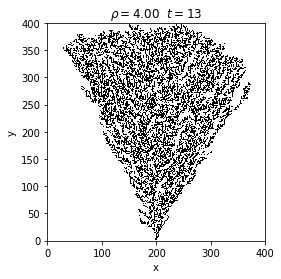

In [143]:
rho = params["r_0"]*params["tau"]

plot_surface(space_flat.transpose(), max_height = None,
            title = r"$\rho = $" + f"{rho:.2f}  " +  r"$t = $" + f"{13:.0f}",
            save = False,
            show = True,)

In [66]:
def calc_empty_zones_temp(space_flat, params):
    def dfs(start_index_double_flat, space_double_flat, visited): #Use Depth-First Search for entire fucking lattice
        stack = [start_index_double_flat]
        current_cluster = [start_idx]
        visited.append(start_index_double_flat)

        while stack:
            current_index = stack.pop()

            for neighbor in get_NNDN_and_time(current_index, params):
                if neighbor not in visited and (space_double_flat[neighbor]==0):
                    stack.append(neighbor)
                    visited.append(neighbor)
                    current_cluster.append(neighbor)
        return current_cluster, visited

    def get_NNDN_and_time(current_index_double_flat, params): #Returns double flat index and also return itself
        shape_prev_flat = (np.power(params['dom'], params["ndim"]), params["height"])
        shape_space = tuple(params["dom"] for _ in range(params["ndim"]))

        # print("Shape_prev_flat:", shape_prev_flat)
        space_index_flat, time_index = np.unravel_index(current_index_double_flat, shape_prev_flat)

        # print("Shape_space:", shape_space)
        neighbors_same_layer = get_nearest_non_diagonal_neighbors(space_index_flat, shape_space)

        double_flat_index = np.ravel_multi_index((space_index_flat, time_index), shape_prev_flat)
        time_neighbors = [double_flat_index]

        for neighbor in neighbors_same_layer:
            try:
                if not time_index-1 < 0:
                    double_flat_index = np.ravel_multi_index((neighbor, time_index-1), shape_prev_flat )
                    time_neighbors.append(double_flat_index)
                
                double_flat_index = np.ravel_multi_index((neighbor, time_index), shape_prev_flat )
                time_neighbors.append(double_flat_index)

                if not time_index+1 >= params["height"]: #This is so that the addition of one doesn't fuck me up
                    double_flat_index = np.ravel_multi_index((neighbor, time_index+1), shape_prev_flat)
                    time_neighbors.append(double_flat_index)
            except ValueError:
                print("DoubleFlatIndexError: |Space_index: ",neighbor,"TimeIndex: ", 
                      time_index, "CastShape: " ,shape_prev_flat)
        return time_neighbors
            
    space_double_flat = np.ravel(space_flat) #Double flat means flat in space and flat in time too
    empty_double_flat_indexes = np.argwhere(space_double_flat==0) # find all double flat indexes in space time

    list_empty_clusters = []
    visited= [] #global variable for tracking visited double flat indexes


    for start_idx in empty_double_flat_indexes:
        if start_idx not in visited:
            
            current_cluster, visited = dfs(start_idx, space_double_flat, visited)
            list_empty_clusters.append(current_cluster)
        
    return list_empty_clusters

In [67]:
list_clusters = calc_empty_zones_temp(space_flat, params)

In [132]:
list_cluster_single_flat = []
shape_prev_flat = (np.power(params["dom"], params["ndim"]), params["height"])

for cluster in list_clusters:
    simple_flag = False
    if 0 in cluster and (params["init_cond"] == "single"):
        continue

    cluster_single_flat = []
    for coord_double_flat in cluster:
        coord_single_flat = np.unravel_index(coord_double_flat, shape_prev_flat)

        if coord_single_flat[1] == params["height"]-1: # Everything connected to last layer is removed
            simple_flag = True
        cluster_single_flat.append(coord_single_flat)
    
    if simple_flag: #Skips the appending, removes a cluster if flag is trigerred
        continue
    
    list_cluster_single_flat.append(cluster_single_flat)

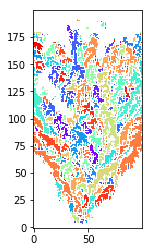

In [138]:
plt.figure()
images = []

colors = plt.cm.rainbow(np.linspace(0, 1, 256))
colors[0, :] = [1, 1, 1, 1]  # Set the first color to white

custom_rainbow_cmap = clrs.ListedColormap(colors)

single_cluster = np.zeros(shape_prev_flat)
for cluster in list_cluster_single_flat:
    random_color = np.random.rand(1)
    for coord in cluster:
        single_cluster[coord[0], coord[1]] = random_color

    img = single_cluster.reshape(shape_prev_flat).transpose()
    plt.imshow(img, cmap=custom_rainbow_cmap, origin= "lower")
    images.append(img)
plt.colormaps
plt.show()